In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
%matplotlib inline 
from  matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

In [2]:
#https://gist.github.com/perrygeo/4512375
def scale_linear_bycolumn(rawpoints, high=1.0, low=0.0):
    mins = np.min(rawpoints, axis=0)
    maxs = np.max(rawpoints, axis=0)
    rng = maxs - mins
    return high - (((high - low) * (maxs - rawpoints)) / rng)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


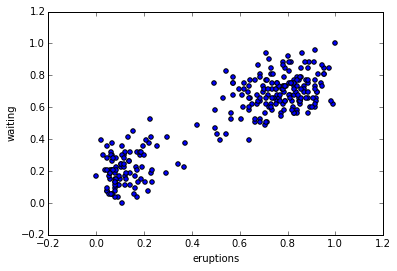

In [4]:
df = pd.read_csv('data.csv')
df.head(5)
df['eruptions'] = scale_linear_bycolumn(df['eruptions'])
df['waiting'] = scale_linear_bycolumn(df['waiting'])
df.plot(kind='scatter', x='eruptions', y='waiting')

In [5]:
from scipy.stats import multivariate_normal

def gmm_mixture(df, mu1=None, cov1=None, mu2=None, cov2=None, p_mix=None):
    df = df[['eruptions', 'waiting']]
    # Take initial guesses for mean vectors, covariance matrices,
    # and mixing proportion
    if mu1 is None: mu1 = np.random.random(2)
    if cov1 is None: cov1 = np.random.random() * np.eye(2)
    if mu2 is None: mu2 = np.random.random(2)
    if cov2 is None: cov2 = np.random.random() * np.eye(2)
    if p_mix is None: p_mix = np.random.random()
    
#     print "RANDOM STEP"
#     print "random mu1 is " + str(mu1)
#     print "random cov1 is " + str(cov1)
#     print "random mu2 is " + str(mu2)
#     print "random cov2 is " + str(cov2)
    
    # E-step: Compute responsibilities
    var1 = multivariate_normal(mean=mu1, cov=cov1)
    var2 = multivariate_normal(mean=mu2, cov=cov2)
    resp = p_mix*var2.pdf(df) / ((1-p_mix)*var1.pdf(df) + p_mix*var2.pdf(df))
    resp = np.array([resp])

    mu1_arr = np.array([mu1])
    mu2_arr = np.array([mu2])
#     print resp.shape
#     print "First E-step"
#     print "var1 is " + str(var1)
#     print "var2 is " + str(var1)
#     print "resp is " + str(np.mean(resp))
#     print "p_mix is  " + str(p_mix)
    
#     print "Mu Arrays 1 and 2"
#     print mu1_arr
#     print mu2_arr
    

    diff = 1
    epsilon = 0.0001
    while diff > epsilon:
        # M-step: compute weighted means and variances
        mu1 = sum((1-resp).dot(df)) / sum(sum(1-resp))
        cov1 = np.diag(sum((1-resp).dot(np.square(df-mu1))) / sum(sum(1-resp)))
        if np.count_nonzero(np.less(cov1, epsilon * np.eye(2))) > 0:
            cov1 = np.random.random() * np.eye(2)

        mu2 = sum(resp.dot(df)) / sum(sum(resp))
        cov2 = np.diag(sum(resp.dot(np.square(df-mu2))) / sum(sum(resp)))
        if np.count_nonzero(np.less(cov2, epsilon * np.eye(2))) > 0:
            cov2 = np.random.random() * np.eye(2)
        
#         print "M-step just finished bitch!"
#         print "mu1 is " + str(mu1)
#         print "cov1 is " + str(cov1)
#         print "mu2 is " + str(mu2)
#         print "cov2 is " + str(cov2)
        
        mu1_arr = np.append(mu1_arr, [mu1], axis=0)
        mu2_arr = np.append(mu2_arr, [mu2], axis=0)
        
        old_p_mix = p_mix
        p_mix = sum(sum(resp)) / len(df)
        #print "p mix muthafuckas : " + str(p_mix)
        
#         print "Middle step"
#         print sum(sum(resp)),len(df),sum(resp)
        
        # E-step: Compute responsibilities
        var1 = multivariate_normal(mean=mu1, cov=cov1)
        var2 = multivariate_normal(mean=mu2, cov=cov2)
        resp = p_mix*var2.pdf(df) / ((1-p_mix)*var1.pdf(df) + p_mix*var2.pdf(df))
        resp = np.array([resp])
        
#         print "E-step just finished bitch!"
#         print "var1 is " + str(var1)
#         print "var2 is " + str(var1)
        #print "resp is " + str(np.mean(resp))
#         print "p_mix is  " + str(p_mix)
        diff = abs(p_mix - old_p_mix)
#         print diff
    return mu1_arr, mu2_arr

In [6]:
gmm_mixture(df)

(array([[ 0.71366555,  0.16754317],
        [ 0.52752293,  0.49814573],
        [ 0.50721081,  0.49900296],
        [ 0.47445735,  0.47512718],
        [ 0.40809701,  0.4239187 ],
        [ 0.29515071,  0.33921591],
        [ 0.18057872,  0.25480791],
        [ 0.14752927,  0.23049127],
        [ 0.1335068 ,  0.22235201],
        [ 0.12605386,  0.2176335 ],
        [ 0.12516748,  0.21688576],
        [ 0.1251215 ,  0.21685023]]), array([[ 0.85547522,  0.55455215],
        [ 0.5512597 ,  0.55469123],
        [ 0.57154782,  0.55373788],
        [ 0.60416878,  0.57750752],
        [ 0.66801445,  0.62675454],
        [ 0.75185078,  0.68918714],
        [ 0.77944759,  0.70806697],
        [ 0.77778643,  0.70638553],
        [ 0.7728884 ,  0.70127813],
        [ 0.76947375,  0.69823933],
        [ 0.76891676,  0.69787076],
        [ 0.76887959,  0.69784364]]))

[ 0.1251209   0.21684978]
[ 0.76887909  0.69784327]


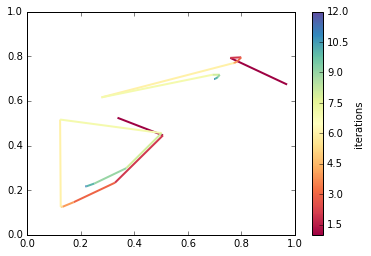

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10721e4d0>]], dtype=object)

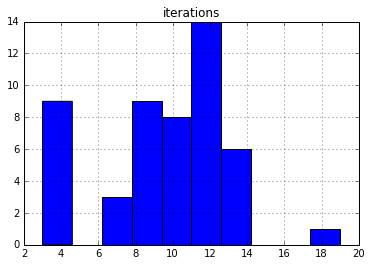

In [26]:
trajectories = []
for i in range(50):
    trajectories.append(gmm_mixture(df))

# http://stackoverflow.com/questions/8945699/gnuplot-linecolor-variable-in-matplotlib/18516488#18516488
fig = plt.figure()

for i in trajectories[0]:
    print i[-1]
    points = np.array(i).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap('Spectral'),
                        norm=plt.Normalize(1, len(i)))
    lc.set_array(np.arange(1,len(i)+1))
    lc.set_linewidth(2)

    plt.gca().add_collection(lc)

axcb = fig.colorbar(lc)
axcb.set_label('iterations')

plt.show()
pd.DataFrame([len(trajectory[0]) for trajectory in trajectories], columns=['iterations']).hist()
